In [1]:
from dysts.flows import Lorenz
from darts.models.forecasting.nbeats import NBEATSModel
from darts.models.forecasting.rnn_model import RNNModel
from darts.models.forecasting.transformer_model import TransformerModel

from data import load_or_generate_and_save
from plot import plot_3d_trajectories, plot_3d_predictions_vs_ground_truth

[2022-03-15 13:54:09,704] WARNING | darts.models | Support for AutoARIMA is not available.To enable it, install u8darts[pmdarima] or u8darts[all].
[2022-03-15 13:54:09,705] WARNING | darts.models | Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).


In [2]:
import torch
torch.manual_seed(0)

import random
random.seed(0)

import numpy as np
np.random.seed(0)

# Experimental settings

In [3]:
data_params = {
    'chaos': 'lorenz',
    'chaos.dt': 50,
    'n_trajectories': 100,
    'trajectory_length': 1000
}
model_params = {
    'network_in': 5,
    'network_out': 1,
    'train_epochs': 5
}
n_trajectories = data_params['n_trajectories']
trajectory_length = data_params['trajectory_length']
network_in = model_params['network_in']
network_out = model_params['network_out']
train_epochs = model_params['train_epochs']

data_params_string = '_'.join([f'{k}_{v}' for k, v in data_params.items()])
models_params_string = '_'.join([f'{k}_{v}' for k, v in model_params.items()])

models = [
    NBEATSModel(input_chunk_length=network_in, output_chunk_length=network_out, num_stacks=10, layer_widths=32),
    RNNModel(input_chunk_length=network_in, model='GRU'),
    TransformerModel(input_chunk_length=network_in, output_chunk_length=network_out)
]
lorenz = Lorenz()
lorenz.dt *= data_params['chaos.dt']

## Load / generate train data

In [4]:
train_set = load_or_generate_and_save(f'data/{data_params_string}_train.npy', chaos_model=lorenz, data_params=data_params, ic_fun=lambda: 20 * np.random.rand(3))

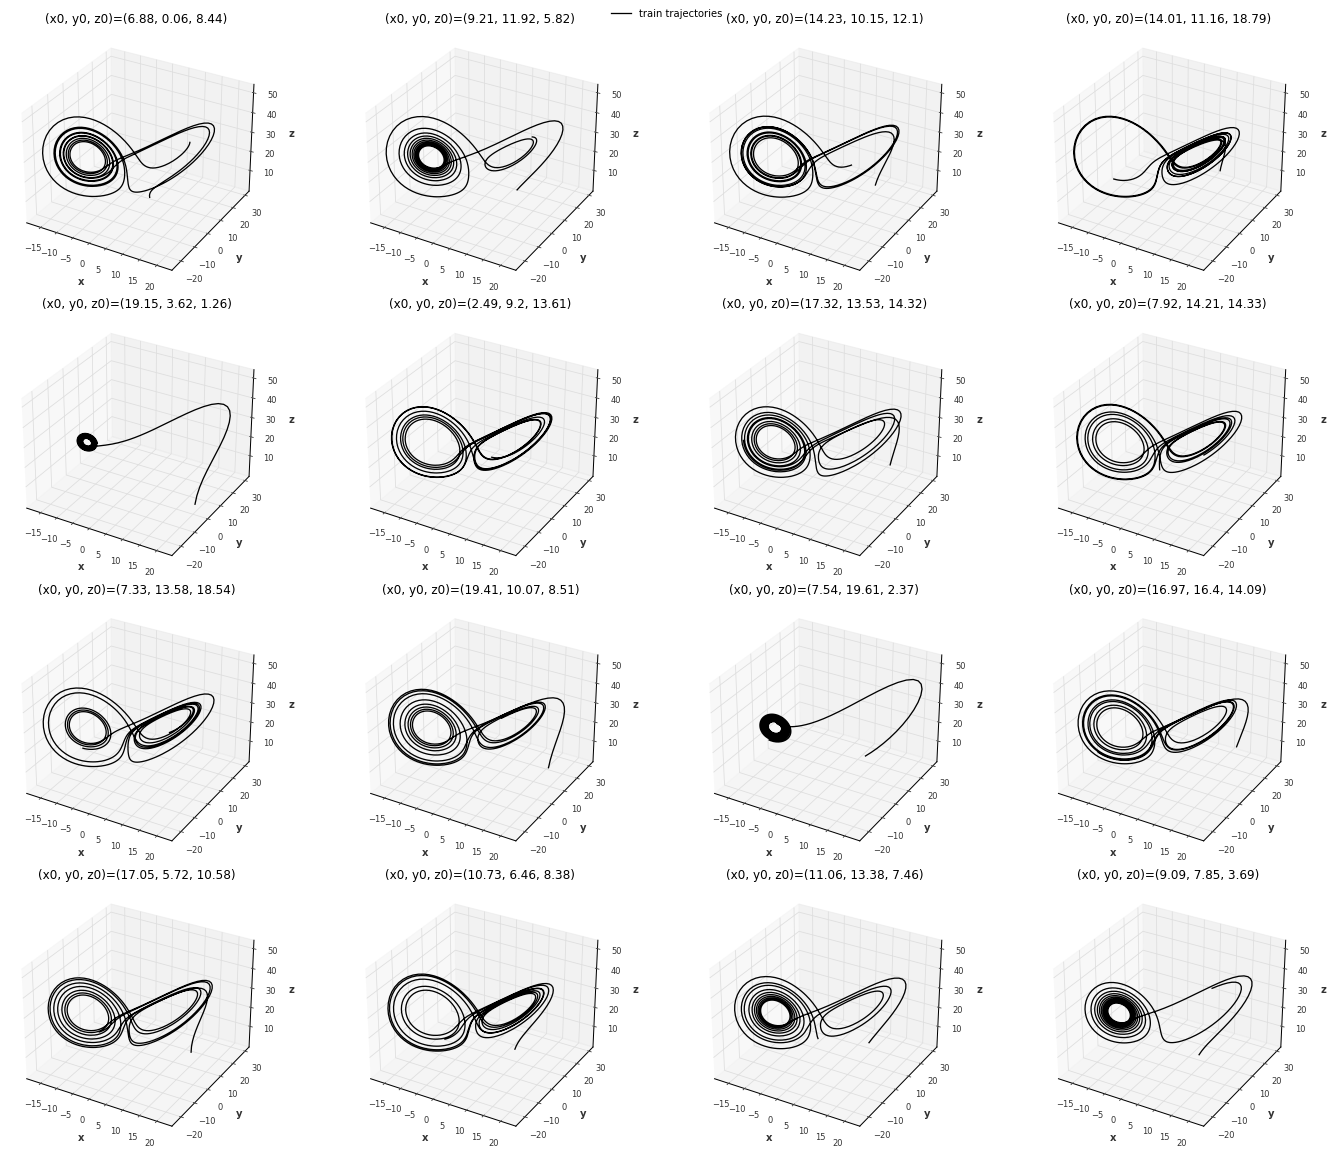

In [5]:
plot_3d_trajectories([train_set], labels=['train trajectories'], n_plots=16);

## Load / generate test data

In [5]:
test_set = load_or_generate_and_save(f'data/{data_params_string}_test.npy', chaos_model=lorenz, data_params=data_params, ic_fun=lambda: -10 * np.random.rand(3))

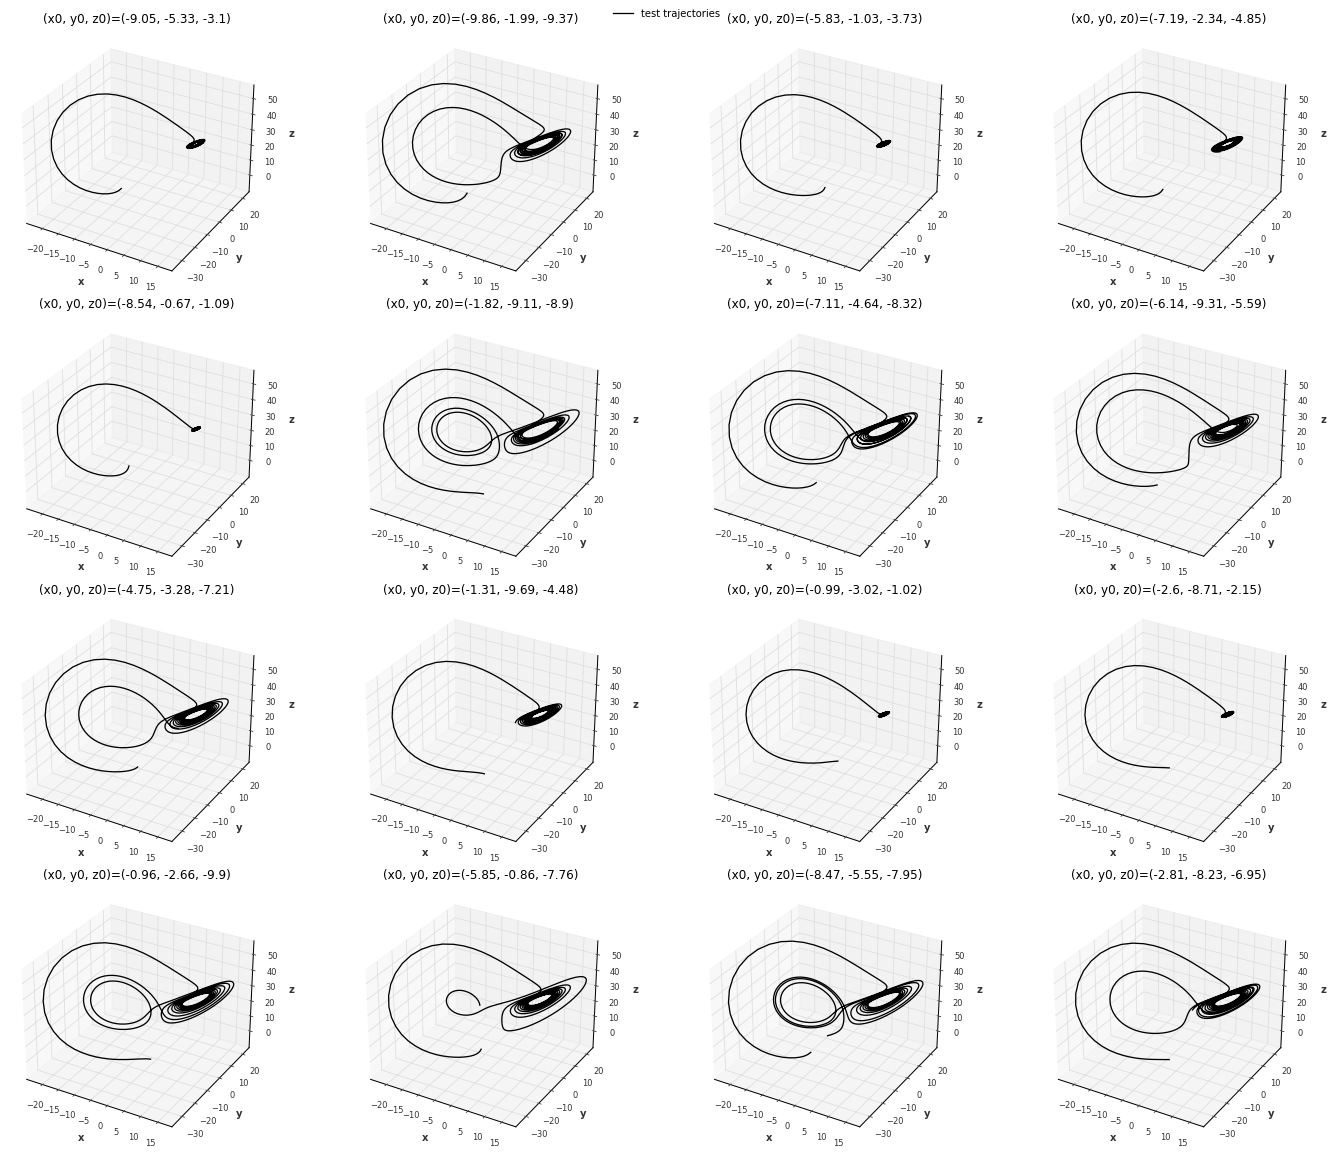

In [7]:
plot_3d_trajectories([test_set], labels=['test trajectories'], n_plots=16);

## Train and save models

In [11]:
for model in models:
    model.fit(train_set, epochs=train_epochs)
    model.save_model(f'models/{data_params_string}_{models_params_string}_{model.__class__.__name__}_{model.model_name}.pth.tar')

[2022-03-15 13:37:04,283] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 97600 samples.
[2022-03-15 13:37:04,283] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 97600 samples.
[2022-03-15 13:37:04,288] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-15 13:37:04,288] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | rnn       | GRU     | 2.2 K 
2 | V         | Linear  | 78    
--------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.019     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[2022-03-15 13:42:23,636] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 99500 samples.
[2022-03-15 13:42:23,636] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 99500 samples.
[2022-03-15 13:42:23,657] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-15 13:42:23,657] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | encoder             | Linear              | 256   
2 | positional_encoding | _PositionalEncoding | 0     
3 | transformer         | Transformer         | 548 K 
4 | decoder             

Training: 0it [00:00, ?it/s]

In [6]:
from darts.models.forecasting.torch_forecasting_model import TorchForecastingModel
import os

models = [TorchForecastingModel.load_model(f'models/{f}') for f in os.listdir('models')]

# Show predictions

Predicting: 3110it [00:00, ?it/s]

Predicting: 3050it [00:00, ?it/s]

Predicting: 3110it [00:00, ?it/s]

([[<TimeSeries (DataArray) (time: 995, component: 3, sample: 1)>
   array([[[ 5.57528415],
           [ 5.25573786],
           [ 7.79633735]],
   
          [[ 5.59982404],
           [ 6.19400017],
           [ 7.86112043]],
   
          [[ 5.69090677],
           [ 7.16827192],
           [ 8.00397873]],
   
          ...,
   
          [[-7.30495933],
           [-7.48554382],
           [26.12109744]],
   
          [[-7.31481329],
           [-7.54890928],
           [26.03667784]],
   
          [[-7.32862093],
           [-7.61387826],
           [25.95998639]]])
   Coordinates:
     * time       (time) int64 5 6 7 8 9 10 11 12 ... 993 994 995 996 997 998 999
     * component  (component) object '0' '1' '2'
   Dimensions without coordinates: sample,
   <TimeSeries (DataArray) (time: 995, component: 3, sample: 1)>
   array([[[11.85489947],
           [20.29290936],
           [12.17608899]],
   
          [[12.57116847],
           [21.88868452],
           [14.07331021]],
   


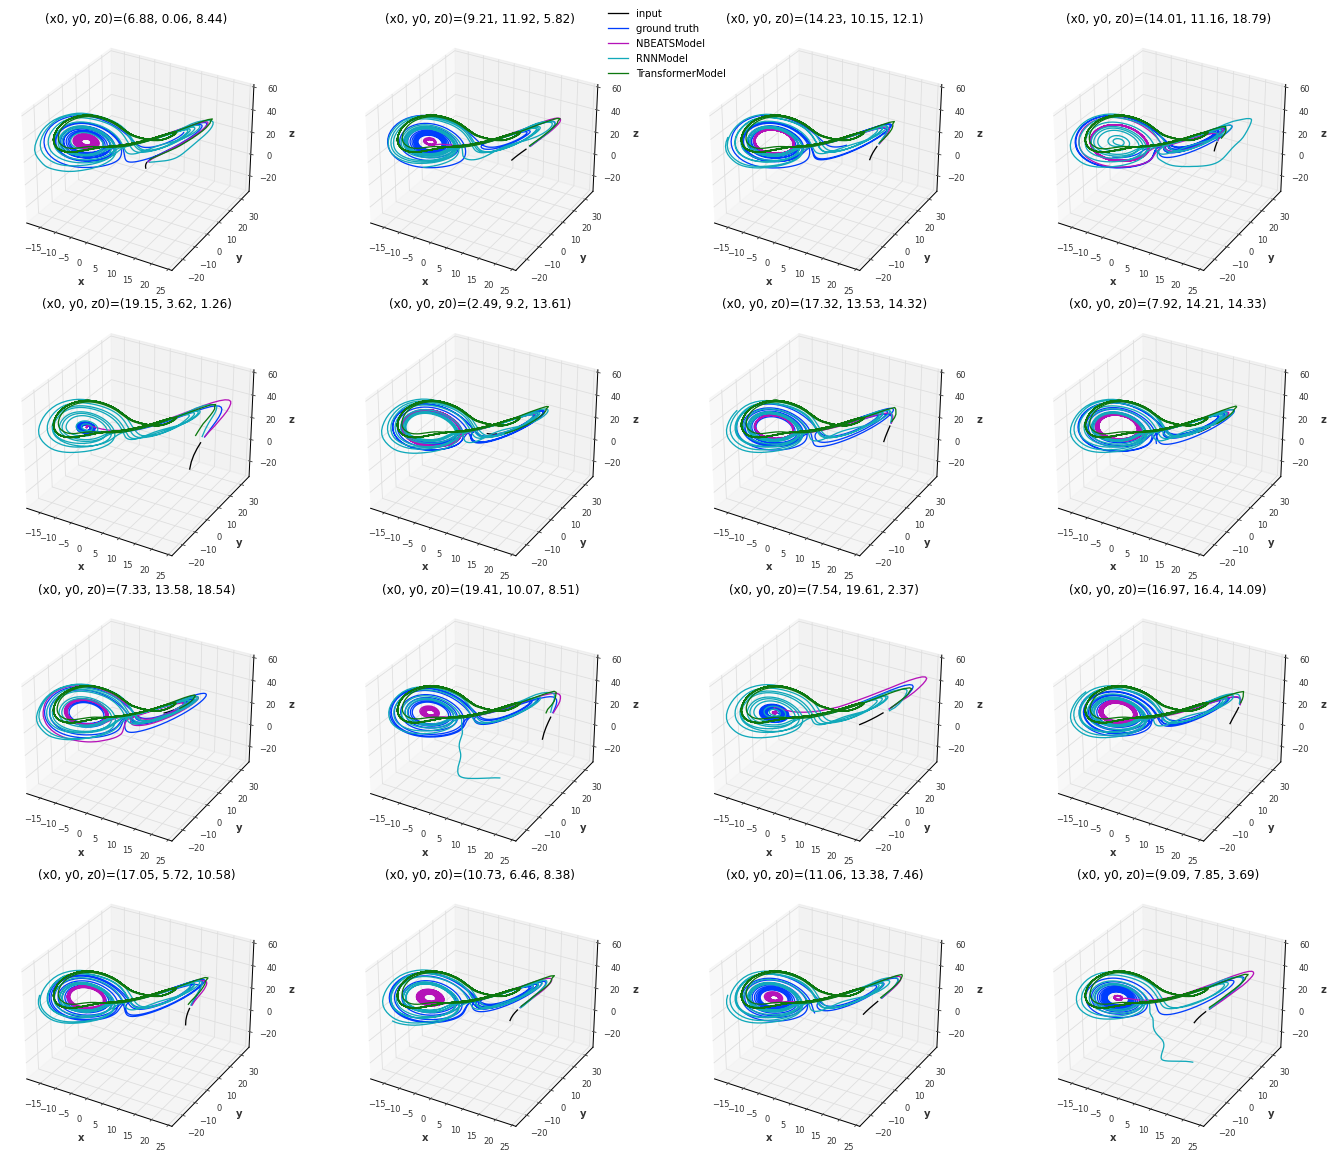

In [7]:
plot_3d_predictions_vs_ground_truth(models, train_set, data_params, model_params);

Predicting: 3110it [00:00, ?it/s]

Predicting: 3050it [00:00, ?it/s]

Predicting: 3110it [00:00, ?it/s]

([[<TimeSeries (DataArray) (time: 995, component: 3, sample: 1)>
   array([[[ -8.28653739],
           [-13.93026014],
           [  5.66240619]],
   
          [[ -8.43034232],
           [-14.39933036],
           [  7.94862912]],
   
          [[ -8.76649346],
           [-14.30270352],
           [ 10.20197479]],
   
          ...,
   
          [[ -4.29329649],
           [ -3.81084418],
           [ 23.98748027]],
   
          [[ -4.25028689],
           [ -3.95356598],
           [ 23.59994247]],
   
          [[ -4.2235045 ],
           [ -4.10829026],
           [ 23.22838989]]])
   Coordinates:
     * time       (time) int64 5 6 7 8 9 10 11 12 ... 993 994 995 996 997 998 999
     * component  (component) object '0' '1' '2'
   Dimensions without coordinates: sample,
   <TimeSeries (DataArray) (time: 995, component: 3, sample: 1)>
   array([[[ -7.3766315 ],
           [-12.02470034],
           [  2.61895939]],
   
          [[ -7.17133686],
           [-12.21484368],
        

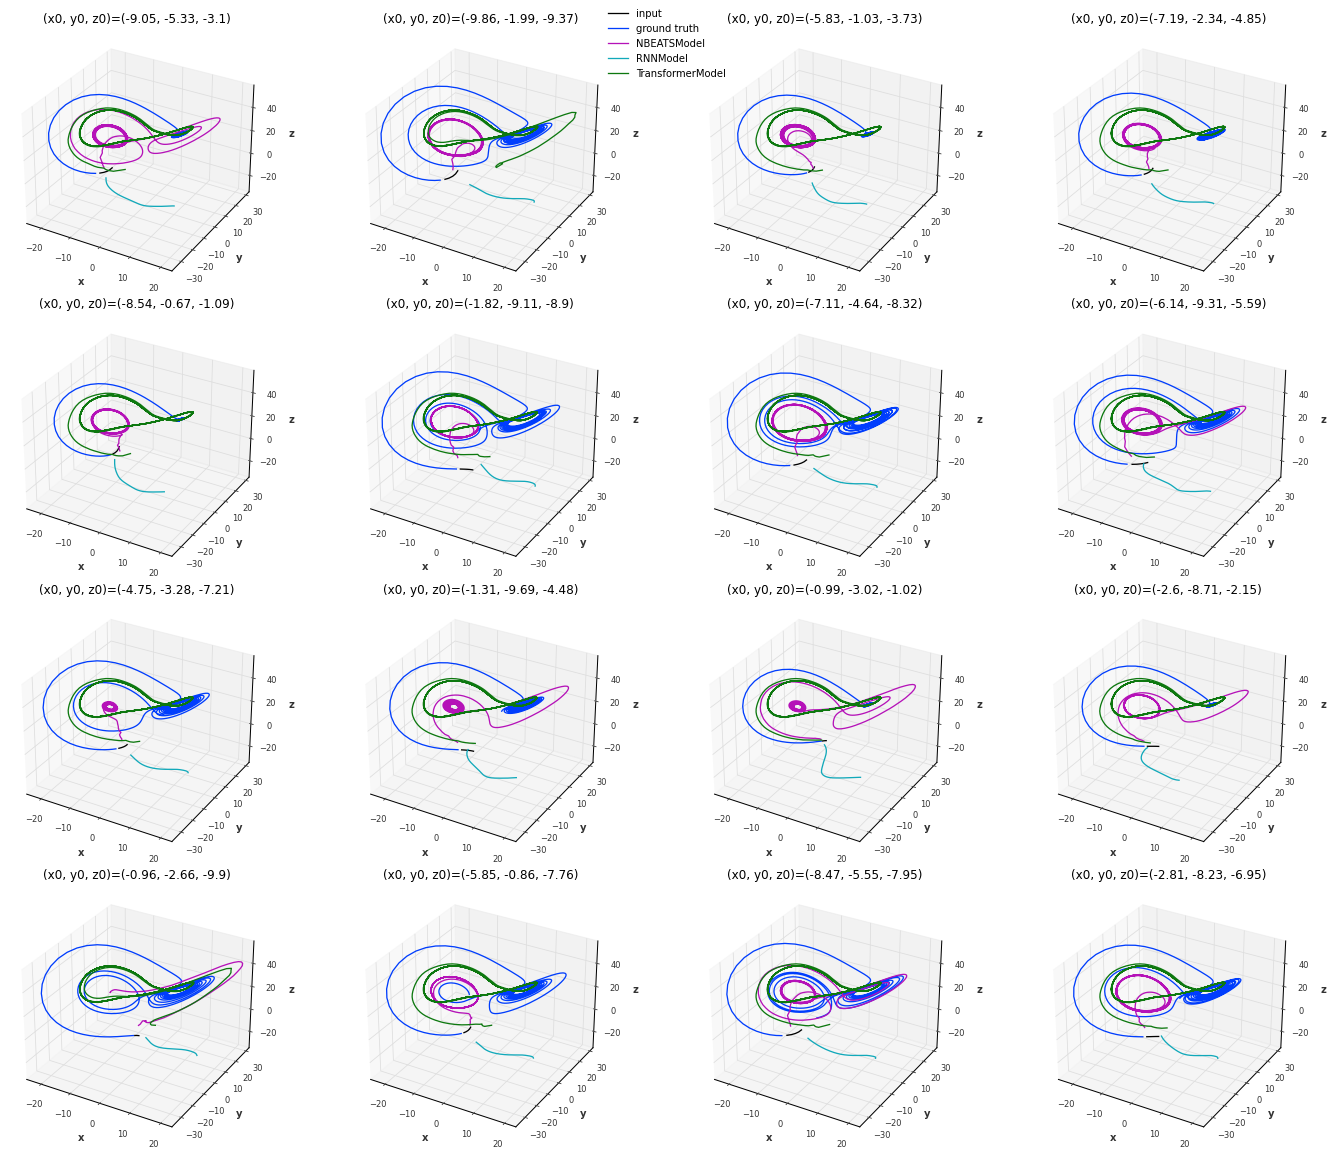

In [8]:
plot_3d_predictions_vs_ground_truth(models, test_set, data_params, model_params);